# DCGAN to generate face images

<img src='./images/dcgan_01.jpeg' width='800'>

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
import torch
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torch.utils.tensorboard import SummaryWriter
# from torchsummary import summary
from torchinfo import summary
from matplotlib import pyplot as plt
import sys

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

## Prepare CelebA data

In [3]:
dataPath = "./data/img_align_celeba"

if not os.path.exists(dataPath):
    os.makedirs(dataPath)
else:
    print(dataPath + " has been processed!")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = dataPath+"/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile(dataPath+"/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

./img_align_celeba has been processed!


In [4]:
dataroot = 'data'
workers = 2
batch_size = 64
image_size = 64
num_channel = 3
latent_dim = 128
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0001
beta1 = 0.5
ngpu = 1

[torchvision transforms doc](https://pytorch.org/vision/stable/transforms.html)

[torchvision datasets doc](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder)

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(image_size), 
     transforms.CenterCrop(image_size), 
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) 
     ])

dataset = ImageFolder(root=dataroot, transform=transform)

dataloader = torch.utils.data.DataLoader(dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=workers)

[tochvision utils doc](https://pytorch.org/vision/stable/utils.html)

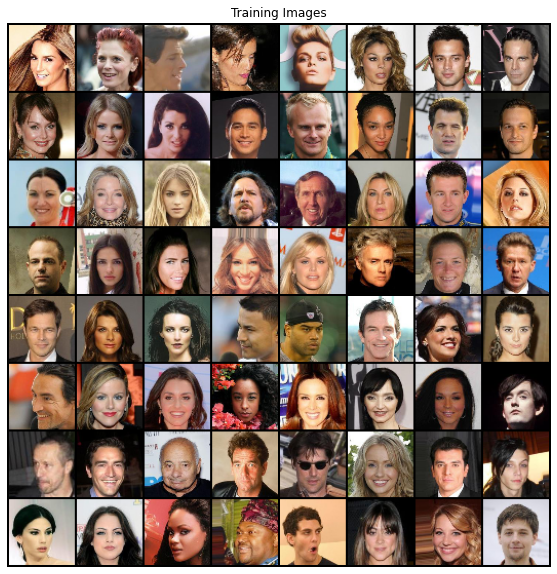

In [6]:
sample_batch = next(iter(dataloader)) 
plt.figure(figsize=(10,10)) 
plt.axis("off") 
plt.title("Training Images") 
plt.imshow(np.transpose(vutils.make_grid(sample_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [7]:
def weights_init(m): 
    classname = m.__class__.__name__ 
    
    if classname.find('Conv') != -1: 
        nn.init.normal_(m.weight.data, 0.0,0.02) 
        
    elif classname.find('BatchNorm') != -1: 
        nn.init.normal_(m.weight.data,1.0,0.02) 
        nn.init.constant_(m.bias.data,0)

## Paper Version

### Create the generator
It mirrors the discriminator, replacing Conv2D layers with Conv2DTranspose layers.

<img src='./images/dcgan_02.png' width='800'>

In [15]:
# Generator 
class Generator(nn.Module): 
    def __init__(self,ngpu): 
        super(Generator, self).__init__() 
        self.ngpu = ngpu 
        self.main = nn.Sequential( 
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, num_channel, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        ) 
        
    def forward(self,input): 
        return self.main(input)

In [55]:
netG = Generator(ngpu).to(device) 

if (device.type=='cuda') and (ngpu>1): 
    netG = nn.DataParallel(netG, list(range(ngpu))) 
netG.apply(weights_init) 
summary(netG, input_size = (64, 128, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                --                        --
├─Sequential: 1-1                        [64, 3, 64, 64]           --
│    └─ConvTranspose2d: 2-1              [64, 512, 4, 4]           1,048,576
│    └─BatchNorm2d: 2-2                  [64, 512, 4, 4]           1,024
│    └─ReLU: 2-3                         [64, 512, 4, 4]           --
│    └─ConvTranspose2d: 2-4              [64, 256, 8, 8]           2,097,152
│    └─BatchNorm2d: 2-5                  [64, 256, 8, 8]           512
│    └─ReLU: 2-6                         [64, 256, 8, 8]           --
│    └─ConvTranspose2d: 2-7              [64, 128, 16, 16]         524,288
│    └─BatchNorm2d: 2-8                  [64, 128, 16, 16]         256
│    └─ReLU: 2-9                         [64, 128, 16, 16]         --
│    └─ConvTranspose2d: 2-10             [64, 64, 32, 32]          131,072
│    └─BatchNorm2d: 2-11                 [64, 64, 32, 32

### Create the discriminator
It maps a 64x64 image to a binary classification score.

In [17]:
# Discriminator 
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(num_channel, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf*4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

In [56]:
netD = Discriminator(ngpu).to(device) 

if (device.type == 'cuda') and (ngpu > 1): 
    netD = nn.DataParallel(netD, list(range(ngpu))) 
netD.apply(weights_init)
summary(netD, input_size = (64, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [64, 1, 1, 1]             --
│    └─Conv2d: 2-1                       [64, 64, 32, 32]          3,072
│    └─LeakyReLU: 2-2                    [64, 64, 32, 32]          --
│    └─Conv2d: 2-3                       [64, 128, 16, 16]         131,072
│    └─BatchNorm2d: 2-4                  [64, 128, 16, 16]         256
│    └─LeakyReLU: 2-5                    [64, 128, 16, 16]         --
│    └─Conv2d: 2-6                       [64, 256, 8, 8]           524,288
│    └─BatchNorm2d: 2-7                  [64, 256, 8, 8]           512
│    └─LeakyReLU: 2-8                    [64, 256, 8, 8]           --
│    └─Conv2d: 2-9                       [64, 512, 4, 4]           2,097,152
│    └─BatchNorm2d: 2-10                 [64, 512, 4, 4]           1,024
│    └─LeakyReLU: 2-11                   [64, 512, 4, 4]    

### Override train_step

In [43]:
class GAN(nn.Module):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = []
        self.g_loss_metric = []

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    def reset_metrics(self):
        self.d_loss_metric = []
        self.g_loss_metric = []

    def train_step(self, batch, use_fp16=False):
        
        # Update D 
        # train with all-real batch 
        self.discriminator.zero_grad()
        real_cpu = batch[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label,
                           dtype=real_cpu.dtype, device=device)

        output = self.discriminator(real_cpu)
        errD_real = self.loss_fn(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        # train with all-fake batch 
        noise = torch.randn(batch_size, self.latent_dim, 1, 1, device=device)
        fake = self.generator(noise)
        label.fill_(fake_label)
        output = self.discriminator(fake.detach())
        errD_fake = self.loss_fn(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        self.d_optimizer.step()
        
        # Update G 
        self.generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = self.discriminator(fake)
        errG = self.loss_fn(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        self.g_optimizer.step()

        return errD.item(), errG.item(), D_x, D_G_z1, D_G_z2        

### Train the end-to-end model

In [57]:
criterion = nn.BCELoss() 
fixed_noise = torch.randn(64,latent_dim,1,1,device=device) 
real_label = 1 
fake_label = 0 
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1,0.999)) 
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1,0.999))

In [58]:
img_list = [] 
G_losses = [] 
D_losses = []
iters = 0

writer = SummaryWriter("log", comment='DCGAN')

gan = GAN(discriminator=netD, generator=netG, latent_dim=latent_dim)
gan.compile(
    d_optimizer=optimizerD,
    g_optimizer=optimizerG,
    loss_fn=criterion,
)

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        gan.reset_metrics()
        errD, errG, D_x, D_G_z1, D_G_z2  = gan.train_step(data)
        writer.add_scalars('GAN', {'errD':errD,
                                    'errG':errG}, iters)
        if i % 50 == 0: 
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader), errD, errG, D_x, D_G_z1, D_G_z2)) 
            
            G_losses.append(errG) 
            D_losses.append(errD) 
            
            
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)): 
                with torch.no_grad(): 
                    fake = netG(fixed_noise).detach().cpu() 
                    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

[0/5][0/3166]	Loss_D: 1.4479	Loss_G: 3.3052	D(x): 0.7031	D(G(z)): 0.5942 / 0.0542
[0/5][50/3166]	Loss_D: 0.1637	Loss_G: 7.6560	D(x): 0.9574	D(G(z)): 0.0552 / 0.0008
[0/5][100/3166]	Loss_D: 0.0656	Loss_G: 11.6922	D(x): 0.9958	D(G(z)): 0.0581 / 0.0000
[0/5][150/3166]	Loss_D: 0.0200	Loss_G: 8.6596	D(x): 0.9869	D(G(z)): 0.0058 / 0.0002
[0/5][200/3166]	Loss_D: 0.0001	Loss_G: 38.2181	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/5][250/3166]	Loss_D: 0.0003	Loss_G: 37.8385	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[0/5][300/3166]	Loss_D: 0.0000	Loss_G: 37.4562	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][350/3166]	Loss_D: 0.0024	Loss_G: 36.9647	D(x): 0.9977	D(G(z)): 0.0000 / 0.0000
[0/5][400/3166]	Loss_D: 0.0000	Loss_G: 36.6382	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][450/3166]	Loss_D: 0.0000	Loss_G: 35.2682	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][500/3166]	Loss_D: 0.0002	Loss_G: 32.8148	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[0/5][550/3166]	Loss_D: 0.0001	Loss_G: 39.2437	D(x): 0.9999	D(G(z)): 0.

[1/5][1650/3166]	Loss_D: 0.1873	Loss_G: 4.1939	D(x): 0.9148	D(G(z)): 0.0801 / 0.0319
[1/5][1700/3166]	Loss_D: 0.2128	Loss_G: 3.4468	D(x): 0.9559	D(G(z)): 0.1326 / 0.0639
[1/5][1750/3166]	Loss_D: 0.3727	Loss_G: 3.1632	D(x): 0.7671	D(G(z)): 0.0315 / 0.0688
[1/5][1800/3166]	Loss_D: 0.2566	Loss_G: 3.4880	D(x): 0.8692	D(G(z)): 0.0718 / 0.0635
[1/5][1850/3166]	Loss_D: 0.2863	Loss_G: 5.5694	D(x): 0.9475	D(G(z)): 0.1838 / 0.0062
[1/5][1900/3166]	Loss_D: 0.3474	Loss_G: 2.7582	D(x): 0.7716	D(G(z)): 0.0386 / 0.0998
[1/5][1950/3166]	Loss_D: 0.1816	Loss_G: 4.7316	D(x): 0.9123	D(G(z)): 0.0590 / 0.0201
[1/5][2000/3166]	Loss_D: 0.1786	Loss_G: 5.0060	D(x): 0.9706	D(G(z)): 0.1260 / 0.0117
[1/5][2050/3166]	Loss_D: 0.2367	Loss_G: 4.3798	D(x): 0.8308	D(G(z)): 0.0263 / 0.0243
[1/5][2100/3166]	Loss_D: 0.4641	Loss_G: 4.7145	D(x): 0.9799	D(G(z)): 0.2917 / 0.0197
[1/5][2150/3166]	Loss_D: 0.1124	Loss_G: 4.7235	D(x): 0.9785	D(G(z)): 0.0825 / 0.0145
[1/5][2200/3166]	Loss_D: 0.4813	Loss_G: 2.4815	D(x): 0.6960	D(G(z

[3/5][100/3166]	Loss_D: 0.2626	Loss_G: 2.8712	D(x): 0.8763	D(G(z)): 0.1071 / 0.0741
[3/5][150/3166]	Loss_D: 0.2638	Loss_G: 3.5018	D(x): 0.9627	D(G(z)): 0.1898 / 0.0389
[3/5][200/3166]	Loss_D: 3.4282	Loss_G: 6.2698	D(x): 0.9971	D(G(z)): 0.9302 / 0.0052
[3/5][250/3166]	Loss_D: 0.2300	Loss_G: 3.4516	D(x): 0.9233	D(G(z)): 0.1240 / 0.0537
[3/5][300/3166]	Loss_D: 0.3200	Loss_G: 2.6525	D(x): 0.7996	D(G(z)): 0.0549 / 0.1128
[3/5][350/3166]	Loss_D: 0.2978	Loss_G: 3.8259	D(x): 0.8818	D(G(z)): 0.1337 / 0.0382
[3/5][400/3166]	Loss_D: 0.5528	Loss_G: 5.0384	D(x): 0.9530	D(G(z)): 0.3596 / 0.0095
[3/5][450/3166]	Loss_D: 0.2539	Loss_G: 3.4700	D(x): 0.9392	D(G(z)): 0.1500 / 0.0463
[3/5][500/3166]	Loss_D: 0.5135	Loss_G: 1.7360	D(x): 0.6731	D(G(z)): 0.0421 / 0.2344
[3/5][550/3166]	Loss_D: 0.3958	Loss_G: 2.5740	D(x): 0.8152	D(G(z)): 0.1292 / 0.1235
[3/5][600/3166]	Loss_D: 0.4386	Loss_G: 2.0405	D(x): 0.6994	D(G(z)): 0.0391 / 0.1712
[3/5][650/3166]	Loss_D: 0.3532	Loss_G: 2.4768	D(x): 0.8054	D(G(z)): 0.0918 /

[4/5][1750/3166]	Loss_D: 0.2906	Loss_G: 4.0287	D(x): 0.9556	D(G(z)): 0.1962 / 0.0256
[4/5][1800/3166]	Loss_D: 1.7270	Loss_G: 4.8651	D(x): 0.9360	D(G(z)): 0.6974 / 0.0216
[4/5][1850/3166]	Loss_D: 0.1704	Loss_G: 4.8610	D(x): 0.8840	D(G(z)): 0.0357 / 0.0137
[4/5][1900/3166]	Loss_D: 0.2745	Loss_G: 2.5794	D(x): 0.8383	D(G(z)): 0.0648 / 0.0992
[4/5][1950/3166]	Loss_D: 0.2753	Loss_G: 4.4190	D(x): 0.9486	D(G(z)): 0.1780 / 0.0168
[4/5][2000/3166]	Loss_D: 0.2284	Loss_G: 4.2282	D(x): 0.8271	D(G(z)): 0.0107 / 0.0265
[4/5][2050/3166]	Loss_D: 0.1484	Loss_G: 3.2296	D(x): 0.9196	D(G(z)): 0.0562 / 0.0583
[4/5][2100/3166]	Loss_D: 0.3726	Loss_G: 2.7620	D(x): 0.7812	D(G(z)): 0.0613 / 0.1083
[4/5][2150/3166]	Loss_D: 0.4738	Loss_G: 5.4142	D(x): 0.9838	D(G(z)): 0.3154 / 0.0064
[4/5][2200/3166]	Loss_D: 0.3121	Loss_G: 3.7365	D(x): 0.9800	D(G(z)): 0.2262 / 0.0358
[4/5][2250/3166]	Loss_D: 0.1547	Loss_G: 3.9750	D(x): 0.8864	D(G(z)): 0.0220 / 0.0274
[4/5][2300/3166]	Loss_D: 0.3878	Loss_G: 1.8275	D(x): 0.7191	D(G(z

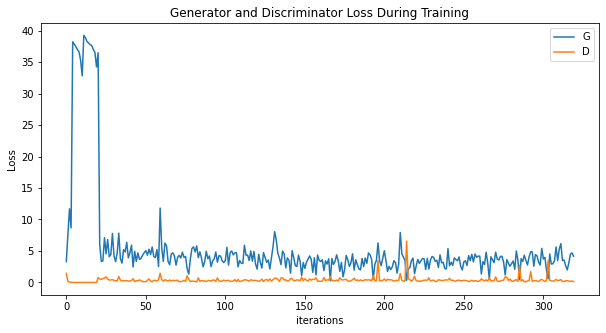

In [59]:
plt.figure(figsize=(10,5)) 
plt.title("Generator and Discriminator Loss During Training") 
plt.plot(G_losses,label="G") 
plt.plot(D_losses,label="D") 
plt.xlabel("iterations") 
plt.ylabel("Loss") 
plt.legend() 
plt.show()

In [60]:
with torch.no_grad(): 
    fake = netG(fixed_noise).detach().cpu() 
    fake_img = vutils.make_grid(fake, padding=2, normalize=True)

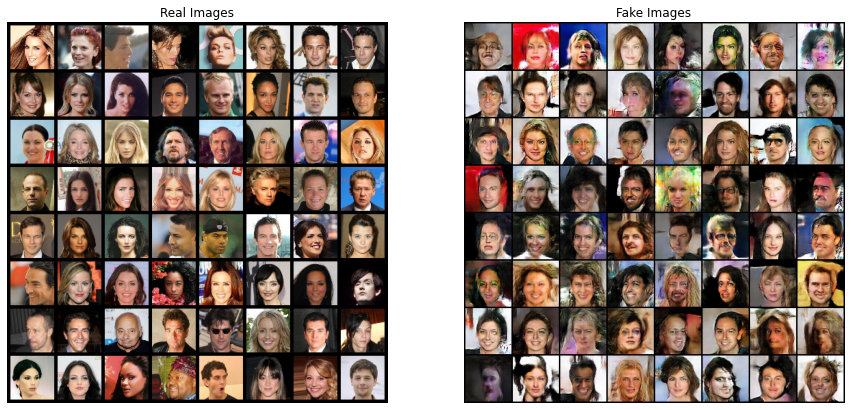

In [61]:
# Grab a batch of real images from the dataloader 
real_batch = next(iter(dataloader)) 
# Plot the real images 
plt.figure(figsize=(15,15)) 
plt.subplot(1,2,1) 
plt.axis("off") 
plt.title("Real Images") 
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0))) 
# Plot the fake images from the last epoch 
plt.subplot(1,2,2) 
plt.axis("off") 
plt.title("Fake Images") 
plt.imshow(np.transpose(fake_img,(1,2,0))) 
plt.show()

---

## Model Visualization

[참고 사이트](https://gaussian37.github.io/dl-pytorch-observe/)

### torchsummary

```bash
pip install torchsummary
```

input_size = (channels, height, width)

In [49]:
from torchsummary import summary
summary(netD, input_size = (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

### torchinfo

```bash
pip install torchinfo
```

input_size=(batch, channel, height, width)

torchsummary의 업데이트가 되지 않고 있다.

LSTM과 같은 RNN 계열의 Summary 시 일부 오류가 났던 문제와 layer 분류를 좀 더 계층적으로 상세히 해준다는 점 등의 개선이 있어서 torchsummary 대신 torchinfo를 사용하는 것을 추천

In [51]:
from torchinfo import summary
summary(netD, input_size = (64, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [64, 1, 1, 1]             --
│    └─Conv2d: 2-1                       [64, 64, 32, 32]          3,072
│    └─LeakyReLU: 2-2                    [64, 64, 32, 32]          --
│    └─Conv2d: 2-3                       [64, 128, 16, 16]         131,072
│    └─BatchNorm2d: 2-4                  [64, 128, 16, 16]         256
│    └─LeakyReLU: 2-5                    [64, 128, 16, 16]         --
│    └─Conv2d: 2-6                       [64, 256, 8, 8]           524,288
│    └─BatchNorm2d: 2-7                  [64, 256, 8, 8]           512
│    └─LeakyReLU: 2-8                    [64, 256, 8, 8]           --
│    └─Conv2d: 2-9                       [64, 512, 4, 4]           2,097,152
│    └─BatchNorm2d: 2-10                 [64, 512, 4, 4]           1,024
│    └─LeakyReLU: 2-11                   [64, 512, 4, 4]    

### torchviz

```bash
pip install graphviz
pip install torchviz
```

In [52]:
from torchviz import make_dot
from torch.autograd import Variable


make_dot(netD(real_batch[0].to(device)), params=dict(netD.named_parameters())).render("./images/graph", format="png")

'../img/graph.png'

<img src='./images/graph.png' width='800'>

### netron


torchsummary나 graphviz와 같이 현재 메모리에 올라가 있는 model을 이용하여 시각화 하는 것이 아니라 파일 형태로 저장한 모델을 이용하여 시각화

저장한 model 파일을 이용하므로 다양한 framework에서 여러 가지 방식으로 저장한 파일들이 호환

[netron 설치 링크](https://github.com/gaussian37/netron)

In [53]:
import torch.onnx
torch.onnx.export(netD, real_batch[0].to(device), "output.onnx", opset_version=11)

### tensorboard

```bash
tensorboard --logdir ./log --host 0.0.0.0
```

In [67]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("log", comment='DCGAN')

In [68]:
img_list = [] 
G_losses = [] 
D_losses = []
ite = 0
gan = GAN(discriminator=netD, generator=netG, latent_dim=latent_dim)
gan.compile(
    d_optimizer=optimizerD,
    g_optimizer=optimizerG,
    loss_fn=criterion,
)

for epoch in range(1):
    for i, data in enumerate(dataloader):
        gan.reset_metrics()
        errD, errG, D_x, D_G_z1, D_G_z2  = gan.train_step(data)
        
        writer.add_scalars('GAN', {'errD':errD,
                                    'errG':errG}, ite)
        if i % 50 == 0: 
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader), errD, errG, D_x, D_G_z1, D_G_z2)) 
            
            G_losses.append(errG) 
            D_losses.append(errD) 
            
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)): 
                with torch.no_grad(): 
                    fake = netG(fixed_noise).detach().cpu() 
                    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        ite += 1

[0/5][0/3166]	Loss_D: 0.1273	Loss_G: 4.3642	D(x): 0.9111	D(G(z)): 0.0242 / 0.0205
[0/5][50/3166]	Loss_D: 0.1810	Loss_G: 4.3774	D(x): 0.9607	D(G(z)): 0.1258 / 0.0185
[0/5][100/3166]	Loss_D: 0.1357	Loss_G: 4.3652	D(x): 0.9666	D(G(z)): 0.0867 / 0.0231
[0/5][150/3166]	Loss_D: 0.1239	Loss_G: 3.4212	D(x): 0.9738	D(G(z)): 0.0866 / 0.0593
[0/5][200/3166]	Loss_D: 0.1491	Loss_G: 3.7118	D(x): 0.8940	D(G(z)): 0.0258 / 0.0407
[0/5][250/3166]	Loss_D: 2.5186	Loss_G: 0.0523	D(x): 0.1532	D(G(z)): 0.0028 / 0.9534
[0/5][300/3166]	Loss_D: 0.8009	Loss_G: 2.5707	D(x): 0.5783	D(G(z)): 0.0204 / 0.1515
[0/5][350/3166]	Loss_D: 0.2157	Loss_G: 4.3584	D(x): 0.9479	D(G(z)): 0.1327 / 0.0202
[0/5][400/3166]	Loss_D: 0.2382	Loss_G: 4.1904	D(x): 0.9643	D(G(z)): 0.1604 / 0.0256
[0/5][450/3166]	Loss_D: 0.2271	Loss_G: 5.3387	D(x): 0.9773	D(G(z)): 0.1662 / 0.0076
[0/5][500/3166]	Loss_D: 0.1920	Loss_G: 2.5169	D(x): 0.8646	D(G(z)): 0.0339 / 0.1164
[0/5][550/3166]	Loss_D: 2.8907	Loss_G: 0.8619	D(x): 0.1209	D(G(z)): 0.0075 / 0.

---